# The IMDb Dataset
The IMDb dataset consists of sentences from movie reviews and human annotations of their sentiment. The task is to predict the sentiment of a given sentence. We use the two-way (positive/negative) class split, and use only sentence-level labels.

In [56]:
from IPython.display import display, Markdown
with open('../../doc/env_variables_setup.md', 'r') as fh:
    content = fh.read()
display(Markdown(content))

Environment variables that need to be defined:   
`export DIR_PROJ=your_path_git_repository`  
`export PYTHONPATH=$DIR_PROJ/src`  
`export PATH_TENSORBOARD=your_path_tensorboard`  
`export PATH_DATASETS=your_path_datasets`  
`export PROJECT_ID=your_gcp_project_id`  
`export BUCKET_NAME=your_gcp_gs_bucket_name`  
`export REGION=your_region`  
`export PATH_SAVE_MODEL=your_path_to_save_model` 

- Use local Jupyter Lab 
    - you need to have the `jupyter-notebook` Anaconda python environment created [link](local_jupyter_lab_installation.md) 
    - you need to have the `jupyter-notebook` Anaconda python environment activated [link](local_jupyter_lab_installation.md) 
    - then define the environment variables above (copy and paste) 
    - you need to have the `env_multilingual_class` Anaconda python environment created [link](local_jupyter_lab_installation.md)  
    - start Jupyter Lab:  `jupyter lab` 
    - open a Jupyter Lab notebook from `notebook/` 
     - clone this repositiory: `git clone https://github.com/tarrade/proj_multilingual_text_classification.git`
    - choose the proper Anaconda python environment:  `Python [conda env:env_multilingual_class]` [link](conda_env.md) 
    - clone this repositiory: `git clone https://github.com/tarrade/proj_multilingual_text_classification.git`


- Use GCP Jupyter Lab 
    - Go on GCP
    - open a Cloud Shell
    - `ssh-keygen -t rsa -b 4096 -C firstName_lastName`
    - `cp .ssh/id_rsa.pub .`
    - use Cloud Editor to edit this file `id_rsa.pub` and copy the full content
    - Go on Compute Engine -> Metadata
    - Click SSH Keys
    - Click Edit
    - Click + Add item, copy the content of `id_rsa.pub`
    - You should see firstName_lastName of the left
    - Click Save
    - you need to start a AI Platform instance 
    - open a Jupyter Lab terminal and got to `/home/gcp_user_name/`
    - clone this repositiory: `git clone https://github.com/tarrade/proj_multilingual_text_classification.git`
    - then `cd proj_multilingual_text_classification/`
    - create the Anacond Python environment `conda env create -f env/environment.yml`
    - create a file `config.sh` in `/home` with the following information: 
    ```
    #!/bin/bash
    
    echo "applying some configuration ..."
    git config --global user.email user_email
    git config --global user.name user_name
    git config --global credential.helper store
        
    # Add here the enviroment variables from above below
    # [EDIT ME]
    export DIR_PROJ=your_path_git_repository
    export PYTHONPATH=$DIR_PROJ/src
  
    cd /home/gcp_user_name/
    
    conda activate env_multilingual_class

    export PS1='\[\e[91m\]\u@:\[\e[32m\]\w\[\e[0m\]$'
    ```
    - Got to AI Platform Notebook, select your instance and click "Reset".
    - Wait and reshreh you Web browser with the Notebook


## Import Packages

In [57]:
import tensorflow as tf
import tensorflow_datasets

from tensorflow.keras.utils import to_categorical

from transformers import (
    BertConfig,
    BertTokenizer,
    TFBertModel,
    TFBertForSequenceClassification,
    glue_convert_examples_to_features,
    glue_processors
)

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

import math
import numpy as np
import os
import time
from datetime import timedelta
import shutil
from datetime import datetime
import pickle

# new
import re
from keras.models import Sequential, load_model

## Check configuration

In [58]:
print(tf.version.GIT_VERSION, tf.version.VERSION)

unknown 2.1.0


In [59]:
print(tf.keras.__version__)

2.2.4-tf


In [60]:
gpus = tf.config.list_physical_devices('GPU')
if len(gpus)>0:
    for gpu in gpus:
        print('Name:', gpu.name, '  Type:', gpu.device_type)
else:
    print('No GPU available !!!!')

No GPU available !!!!


## Define Paths

In [61]:
# note: these need to be specified in the config.sh file
try:
    data_dir=os.environ['PATH_DATASETS']
except KeyError:
    print('missing PATH_DATASETS')
try:   
    tensorboard_dir=os.environ['PATH_TENSORBOARD']
except KeyError:
    print('missing PATH_TENSORBOARD')
try:   
    savemodel_dir=os.environ['PATH_SAVE_MODEL']
except KeyError:
    print('missing PATH_SAVE_MODEL')

## Import local packages

In [62]:
import preprocessing.preprocessing as pp
import utils.model_metrics as mm

In [63]:
import importlib
importlib.reload(pp);
importlib.reload(mm);

## Loading a data from Tensorflow Datasets

In [64]:
data, info = tensorflow_datasets.load(name="imdb_reviews",
                            data_dir=data_dir,
                            as_supervised=True,
                            with_info=True)

INFO:absl:No config specified, defaulting to first: imdb_reviews/plain_text
INFO:absl:Overwrite dataset info from restored data version.
INFO:absl:Reusing dataset imdb_reviews (/home/vera_luechinger/data/imdb_reviews/plain_text/1.0.0)
INFO:absl:Constructing tf.data.Dataset for split None, from /home/vera_luechinger/data/imdb_reviews/plain_text/1.0.0


In [65]:
# IMDb specific:
data_valid = data['test'].take(1000)

# trying to create a true validation data set for after the computation
#data_valid_ext = data['test'].take(2000)
#data_valid = data_valid_ext.take(1000)

### Checking basic info from the metadata

In [66]:
info

tfds.core.DatasetInfo(
    name='imdb_reviews',
    version=1.0.0,
    description='Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=100000,
    splits={
        'test': 25000,
        'train': 25000,
        'unsupervised': 50000,
    },
    supervised_keys=('text', 'label'),
    citation="""@InProceedings{maas-EtAl:2011:ACL-HLT2011,
      author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Potts, Christopher},
      title     = {Learning Word

In [67]:
pp.print_info_dataset(info)

Labels:
      ['neg', 'pos']

Number of label:
      2

Structure of the data:
      dict_keys(['text', 'label'])

Number of entries:
   Train dataset: 25000
   Test dataset:  25000
--> validation dataset not defined


### Checking basic info from the metadata

In [68]:
data

{'test': <DatasetV1Adapter shapes: ((), ()), types: (tf.string, tf.int64)>,
 'train': <DatasetV1Adapter shapes: ((), ()), types: (tf.string, tf.int64)>,
 'unsupervised': <DatasetV1Adapter shapes: ((), ()), types: (tf.string, tf.int64)>}

In [69]:
data.keys()

dict_keys(['test', 'train', 'unsupervised'])

In [70]:
# only works for glue-compatible datasets
try:
    pp.print_info_data(data['train'])
except AttributeError:
    print('data format incompatible')


# Structure of the data:

   <DatasetV1Adapter shapes: ((), ()), types: (tf.string, tf.int64)>

# Output shape of one entry:
   (TensorShape([]), TensorShape([]))

# Output types of one entry:
   (tf.string, tf.int64)

# Output typesof one entry:
   (<class 'tensorflow.python.framework.ops.Tensor'>, <class 'tensorflow.python.framework.ops.Tensor'>)
 

# Shape of the data:

   (25000, 2)
data format incompatible


## Define parameters of the model

In [71]:
# changes: had to eliminate all lines concerning a test data set because we only have train and valid


# define parameters
BATCH_SIZE_TRAIN = 32
BATCH_SIZE_TEST = 32
BATCH_SIZE_VALID = 64
EPOCH = 2
TOKENIZER = 'bert-base-multilingual-uncased'
MAX_LENGTH = 512

# extract parameters
size_train_dataset = info.splits['train'].num_examples

# the size for the validation data set has been manually computed according to the function 
# pp.print_info_data because the test set has been manually split above
size_valid_dataset = np.shape(np.array(list(data_valid.as_numpy_iterator())))[0]
number_label = info.features["label"].num_classes

# computer parameter
STEP_EPOCH_TRAIN = math.ceil(size_train_dataset/BATCH_SIZE_TRAIN)
STEP_EPOCH_VALID = math.ceil(size_valid_dataset/BATCH_SIZE_VALID)


print('Dataset size:          {:6}/{:6}'.format(size_train_dataset, size_valid_dataset))
print('Batch size:            {:6}/{:6}'.format(BATCH_SIZE_TRAIN, BATCH_SIZE_VALID))
print('Step per epoch:        {:6}/{:6}'.format(STEP_EPOCH_TRAIN, STEP_EPOCH_VALID))
print('Total number of batch: {:6}/{:6}'.format(STEP_EPOCH_TRAIN*(EPOCH+1), STEP_EPOCH_VALID*(EPOCH+1)))

Dataset size:           25000/  1000
Batch size:                32/    64
Step per epoch:           782/    16
Total number of batch:   2346/    48


## Tokenizer and prepare data for BERT

In [72]:
# Load tokenizer
tokenizer = BertTokenizer.from_pretrained(TOKENIZER)

In [73]:
# recap of input dataset
print(data['train'])
print(tf.data.experimental.cardinality(data['train']))
print(tf.data.experimental.cardinality(data_valid))
# super slow since looping over all data
#print(len(list(data['train'])))

<DatasetV1Adapter shapes: ((), ()), types: (tf.string, tf.int64)>
tf.Tensor(-2, shape=(), dtype=int64)
tf.Tensor(-2, shape=(), dtype=int64)


### Additional steps for the IMDb dataset specifically

#### Cleaning

In [74]:
def preprocess_reviews(reviews):
    #REPLACE_NO_SPACE = re.compile("[.;:!\'?,\"()\[\]]")
    REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
    
    #ae, oe, ue => only for GERMAN data
    #REPLACE_UMLAUT_AE = re.compile("(ae)")
    #REPLACE_UMLAUT_OE = re.compile("(oe)")
    #REPLACE_UMLAUT_UE = re.compile("(ue)")
    
    #reviews = [REPLACE_NO_SPACE.sub("", line[0].decode("utf-8").lower()) for line in np.array(list(reviews.as_numpy_iterator()))]
    reviews = [REPLACE_WITH_SPACE.sub(" ", line[0].decode("utf-8")) for line in np.array(list(reviews.as_numpy_iterator()))]# for line in reviews]
    #reviews = [REPLACE_UMLAUT_AE.sub("ä", line[0]) for line in reviews]
    #reviews = [REPLACE_UMLAUT_OE.sub("ö", line[0]) for line in reviews]
    #reviews = [REPLACE_UMLAUT_UE.sub("ü", line[0]) for line in reviews]
    
    return reviews

In [75]:
reviews_train_clean = preprocess_reviews(data['train'])
reviews_valid_clean = preprocess_reviews(data_valid)

#### Converting Data to GLUE Format

In [76]:
labels_train = [int(line[1].decode("utf-8")) for line in np.array(list(data['train'].as_numpy_iterator()))]
labels_valid = [int(line[1].decode("utf-8")) for line in np.array(list(data_valid.as_numpy_iterator()))]

In [77]:
train_data_np = pp.convert_np_array_to_glue_format(reviews_train_clean, labels_train)
valid_data_np = pp.convert_np_array_to_glue_format(reviews_valid_clean, labels_valid, shift=len(list(train_data_np)))

In [78]:
# Prepare data for BERT
train_dataset = glue_convert_examples_to_features(train_data_np, 
                                                  tokenizer, 
                                                  max_length=MAX_LENGTH, 
                                                  task='sst-2')
valid_dataset = glue_convert_examples_to_features(valid_data_np, 
                                                  tokenizer, 
                                                  max_length=MAX_LENGTH, 
                                                  task='sst-2')

In [79]:
# recap of pre processing dataset
print(train_dataset)
print(tf.data.experimental.cardinality(train_dataset))
print(tf.data.experimental.cardinality(valid_dataset))
# super slow since looping over all data
print(len(list(train_dataset)))

<FlatMapDataset shapes: ({input_ids: (None,), attention_mask: (None,), token_type_ids: (None,)}, ()), types: ({input_ids: tf.int32, attention_mask: tf.int32, token_type_ids: tf.int32}, tf.int64)>
tf.Tensor(-2, shape=(), dtype=int64)
tf.Tensor(-2, shape=(), dtype=int64)
25000


In [80]:
# set shuffle and batch size
train_dataset = train_dataset.shuffle(100).batch(BATCH_SIZE_TRAIN).repeat(EPOCH+1)
valid_dataset = valid_dataset.batch(BATCH_SIZE_VALID) #.repeat(EPOCH+1)

## Check the final data

In [81]:
pp.print_info_data(train_dataset,print_example=False)

# Structure of the data:

   <RepeatDataset shapes: ({input_ids: (None, None), attention_mask: (None, None), token_type_ids: (None, None)}, (None,)), types: ({input_ids: tf.int32, attention_mask: tf.int32, token_type_ids: tf.int32}, tf.int64)>

# Output shape of one entry:
   ({'input_ids': TensorShape([None, None]), 'attention_mask': TensorShape([None, None]), 'token_type_ids': TensorShape([None, None])}, TensorShape([None]))

# Output types of one entry:
   ({'input_ids': tf.int32, 'attention_mask': tf.int32, 'token_type_ids': tf.int32}, tf.int64)

# Output typesof one entry:
   ({'input_ids': <class 'tensorflow.python.framework.ops.Tensor'>, 'attention_mask': <class 'tensorflow.python.framework.ops.Tensor'>, 'token_type_ids': <class 'tensorflow.python.framework.ops.Tensor'>}, <class 'tensorflow.python.framework.ops.Tensor'>)
 

# Shape of the data:

   (2346, 2)
   ---> 2346 batches
   ---> 2 dim
        label
           shape: (32,)
        dict structure
           dim: 3
        

In [82]:
pp.print_info_data(valid_dataset,print_example=False)

# Structure of the data:

   <BatchDataset shapes: ({input_ids: (None, None), attention_mask: (None, None), token_type_ids: (None, None)}, (None,)), types: ({input_ids: tf.int32, attention_mask: tf.int32, token_type_ids: tf.int32}, tf.int64)>

# Output shape of one entry:
   ({'input_ids': TensorShape([None, None]), 'attention_mask': TensorShape([None, None]), 'token_type_ids': TensorShape([None, None])}, TensorShape([None]))

# Output types of one entry:
   ({'input_ids': tf.int32, 'attention_mask': tf.int32, 'token_type_ids': tf.int32}, tf.int64)

# Output typesof one entry:
   ({'input_ids': <class 'tensorflow.python.framework.ops.Tensor'>, 'attention_mask': <class 'tensorflow.python.framework.ops.Tensor'>, 'token_type_ids': <class 'tensorflow.python.framework.ops.Tensor'>}, <class 'tensorflow.python.framework.ops.Tensor'>)
 

# Shape of the data:

   (16, 2)
   ---> 16 batches
   ---> 2 dim
        label
           shape: (64,)
        dict structure
           dim: 3
           [i

In [83]:
pp.print_detail_tokeniser(train_dataset, tokenizer, max_entries=40)

 input_ids     ---->    attention_mask    token_type_ids    modified text                 

       101     ---->           1                 1          [ C L S ]                     
     12002     ---->           1                 1          e l e                         
     12106     ---->           1                 1          # # g a n                     
     10421     ---->           1                 1          # # c e                       
     10110     ---->           1                 1          a n d                         
     12728     ---->           1                 1          c l a s s                     
     10320     ---->           1                 1          a r e                         
     10497     ---->           1                 1          n o t                         
     17503     ---->           1                 1          a l w a y s                   
     10103     ---->           1                 1          t h e                        

## Building a classification model

### Define the callbacks

#### Checkpoints

In [84]:
# Define the checkpoint directory to store the checkpoints
checkpoint_dir=savemodel_dir+'/checkpoint_model'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

In [85]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                                         save_weights_only=True),
                                                         #save_freq=2000),

#### Decaying learning rate

In [86]:
# Function for decaying the learning rate.
def decay(epoch):
    if epoch < 3:
        return 1e-3
    elif epoch >= 3 and epoch < 7:
        return 1e-4
    else:
        return 1e-5

In [87]:
decay_callback = tf.keras.callbacks.LearningRateScheduler(decay)

#### Print learning rate at the end of each epoch

In [88]:
# Callback for printing the LR at the end of each epoch.
class PrintLR(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print('\nLearning rate for epoch {} is {}'.format(epoch + 1, model.optimizer.lr.numpy()))

#### TensorBoard

In [89]:
# checking existing folders
for i in os.listdir(tensorboard_dir):
    if os.path.isdir(tensorboard_dir+'/'+i):
        print(i)

20200408-060507


In [90]:
# clean old TensorBoard directory 
for i in os.listdir(tensorboard_dir):
        if os.path.isdir(tensorboard_dir+'/'+i):
            print(i)
            shutil.rmtree(tensorboard_dir+'/'+i, ignore_errors=False)

20200408-060507


In [91]:
log_dir=tensorboard_dir+'/'+datetime.now().strftime("%Y%m%d-%H%M%S")
os.mkdir(log_dir)

In [92]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
                                                      histogram_freq=1, 
                                                      embeddings_freq=1,
                                                      write_graph=True,
                                                      update_freq='batch',
                                                      profile_batch=2)

#### Loss and efficiency per step

In [93]:
class History_per_step(tf.keras.callbacks.Callback):
    
    def __init__(self, validation_data, N):
        self.validation_data = validation_data
        self.N = N
        self.batch = 1

    def on_train_begin(self, validation_data, logs={}):
        self.steps = []
        self.losses = []
        self.accuracies = []
        self.val_steps = []
        self.val_losses = []
        self.val_accuracies = []

    def on_train_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accuracies.append(logs.get('accuracy'))
        self.steps.append(self.batch)
        print('\n training set -> batch:{} loss:{} and acc: {}'.format(self.batch,logs.get('loss'),logs.get('accuracy')))
        
        if self.batch % self.N == 0:
            loss_val, acc_val = self.model.evaluate(self.validation_data, verbose=0)
            self.val_losses.append(loss_val)
            self.val_accuracies.append(acc_val)
            self.val_steps.append(self.batch)
            print('\n validation set -> batch:{} val loss:{} and val acc: {}'.format(self.batch,loss_val, acc_val))

        self.batch += 1
    
    def on_test_batch_end(self, batch, logs={}):    
        #print('{}\n'.format(logs))
        return
    
    def on_epoch_end(self, batch, logs={}): 
        #print('{}\n'.format(logs))
        return

### Checks callbacks

In [94]:
list_callback = [tensorboard_callback, checkpoint_callback, decay_callback]
for cb in list_callback:
    if type(cb).__name__=='tuple':
        print(cb[0].__class__.__name__, 'need to unpack this tuple by adding *')

ModelCheckpoint need to unpack this tuple by adding *


### Use TFBertForSequenceClassification

In [95]:
# Define some parameters
#optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
# switched to default values

optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08)
# Gradient clipping in the optimizer (by setting clipnorm or clipvalue) is currently unsupported when using a distribution strategy
# clipnorm=1.0

# loss
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Uses the tf.distribute.MirroredStrategy, which does in-graph replication with synchronous training on many GPUs on one machine
strategy_model_1 = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy_model_1.num_replicas_in_sync))

# create and compile the Keras model in the context of strategy.scope
with strategy_model_1.scope():
    # metric
    metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
    
    # model
    model_1 = TFBertForSequenceClassification.from_pretrained(TOKENIZER,num_labels=number_label)
    #model.layers[-1].activation = tf.keras.activations.softmax
    model_1._name='tf_bert_classification'
    model_1.compile(optimizer=optimizer,
                    loss=loss, 
                    metrics=[metric])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


Number of devices: 1


In [96]:
model_1.summary()

Model: "tf_bert_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  167356416 
_________________________________________________________________
dropout_113 (Dropout)        multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 167,357,954
Trainable params: 167,357,954
Non-trainable params: 0
_________________________________________________________________


### Building a custom classification model 

In [97]:
def custom_keras_model(number_classes, bert_model):

    # create model
    input_layer = tf.keras.Input(shape = (128,), dtype='int64')    
    bert_ini = TFBertModel.from_pretrained('bert-base-cased') (input_layer)
    # This is because in a bert pretraining progress, there are two tasks: 
    # masked token prediction and next sentence predition . 
    # The first needs hidden state of each tokens ( shape: [batch_size, sequence_length, hidden_size]) 
    # the second needs the embedding of the whole sequence (shape : [batch_size, hidden_size] ) .
    bert = bert_ini[1]    
    dropout = tf.keras.layers.Dropout(0.1)(bert)
    flat = tf.keras.layers.Flatten()(dropout)
    classifier = tf.keras.layers.Dense(units=number_classes )(flat) # activation='softmax'               
    
    model = tf.keras.Model(inputs=input_layer, outputs=classifier, name='custom_tf_bert_classification')

    return model, bert_ini

In [98]:
# Define some parameters
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08)
# Gradient clipping in the optimizer (by setting clipnorm or clipvalue) is currently unsupported when using a distribution strategy
# clipnorm=1.0

# loss
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Uses the tf.distribute.MirroredStrategy, which does in-graph replication with synchronous training on many GPUs on one machine
strategy_model_2 = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy_model_1.num_replicas_in_sync))

# create and compile the Keras model in the context of strategy.scope
with strategy_model_2.scope():
    # metric
    metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
    
    # model
    model_2, bert_ini = custom_keras_model(number_label, 'bert-base-cased')
    model_2.compile(optimizer=optimizer,
                    loss=loss, 
                    metrics=[metric])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


Number of devices: 1


In [99]:
bert_ini[0]

<tf.Tensor 'tf_bert_model_1/Identity:0' shape=(None, 128, 768) dtype=float32>

In [100]:
bert_ini[1]

<tf.Tensor 'tf_bert_model_1/Identity_1:0' shape=(None, 768) dtype=float32>

In [101]:
model_2.summary()

Model: "custom_tf_bert_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
tf_bert_model_1 (TFBertModel ((None, 128, 768), (None, 108310272 
_________________________________________________________________
dropout_151 (Dropout)        (None, 768)               0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1538      
Total params: 108,311,810
Trainable params: 108,311,810
Non-trainable params: 0
_________________________________________________________________


### Choose the model you want to train

In [102]:
#model=model_2
model=model_1
print('model\'s name: {}'.format(model.name))

model's name: tf_bert_classification


### TensorBoard

In [103]:
%load_ext tensorboard
#%reload_ext tensorboard
%tensorboard  --logdir   {log_dir}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### Final feature extraction

In [104]:
def data_feature_extraction(data, name):
    if name=='custom_tf_bert_classification':
        print('custom model: {}'.format(name))
        return data.map(pp.feature_selection)
    elif name=='tf_bert_classification':
        print('standard model: {}'.format(name))
        return data
    else:
        print('!!! non defined model !!!!')
        return data

### Training the model

In [50]:
# time the function
start_time = time.time()

# making the transformation here since inside model.fit it creates a lot of warnings
data_train = data_feature_extraction(train_dataset, model.name)
data_val = data_feature_extraction(valid_dataset, model.name)
histories_per_step = History_per_step(data_val, 50)

# train the model
history = model.fit(data_train, 
                    epochs=1, 
                    steps_per_epoch=782, #STEP_EPOCH_TRAIN,
                    validation_data=data_val,
                    validation_steps=16,
                    callbacks=[tensorboard_callback,
                               *checkpoint_callback,
                               histories_per_step])

# print execution time
elapsed_time_secs = time.time() - start_time
print('\nexecution time: {}'.format(timedelta(seconds=round(elapsed_time_secs))))

standard model: tf_bert_classification
standard model: tf_bert_classification
Train for 782 steps, validate for 16 steps

 training set -> batch:1 loss:0.7164592742919922 and acc: 0.53125
  1/782 [..............................] - ETA: 12:00:19 - loss: 0.7165 - accuracy: 0.5312
 training set -> batch:2 loss:0.6882442235946655 and acc: 0.53125
  2/782 [..............................] - ETA: 8:38:23 - loss: 0.7024 - accuracy: 0.5312 
 training set -> batch:3 loss:0.7042034864425659 and acc: 0.5
  3/782 [..............................] - ETA: 7:31:41 - loss: 0.7030 - accuracy: 0.5000
 training set -> batch:4 loss:0.6816699504852295 and acc: 0.515625
  4/782 [..............................] - ETA: 6:58:00 - loss: 0.6976 - accuracy: 0.5156
 training set -> batch:5 loss:0.6940509676933289 and acc: 0.518750011920929
  5/782 [..............................] - ETA: 6:38:38 - loss: 0.6969 - accuracy: 0.5188
 training set -> batch:6 loss:0.686844527721405 and acc: 0.5260416865348816
  6/782 [....

### Save the model

In [51]:
savemodel_path = os.path.join(savemodel_dir, 'saved_model')
os.makedirs(savemodel_path, exist_ok=True)

In [52]:
model.save(os.path.join(savemodel_path,model.name))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: /home/vera_luechinger/save_model/saved_model/tf_bert_classification/assets


INFO:tensorflow:Assets written to: /home/vera_luechinger/save_model/saved_model/tf_bert_classification/assets


In [53]:
# check the saved model
print('Model: {}'.format(model.name))
for i in os.listdir(os.path.join(savemodel_path,model.name)):
        print(' ',i)
            

Model: tf_bert_classification
  assets
  variables
  saved_model.pb


### Save the histories

In [54]:
with open(savemodel_path+'/history', 'wb') as file:
    model_history= mm.History_trained_model(history.history, history.epoch, history.params)
    pickle.dump(model_history, file, pickle.HIGHEST_PROTOCOL)

In [55]:
with open(savemodel_path+'/history_per_step', 'wb') as file:
    model_history_per_step= mm.History_per_steps_trained_model(histories_per_step.steps, 
                                                               histories_per_step.losses, 
                                                               histories_per_step.accuracies, 
                                                               histories_per_step.val_steps, 
                                                               histories_per_step.val_losses, 
                                                               histories_per_step.val_accuracies)
    pickle.dump(model_history_per_step, file, pickle.HIGHEST_PROTOCOL)

## Uploading the classification model

### Loading the model

In [105]:
savemodel_path = os.path.join(savemodel_dir, 'saved_model')
os.makedirs(savemodel_path, exist_ok=True)

In [106]:
model=tf.keras.models.load_model(os.path.join(savemodel_path, 'tf_bert_classification'))

In [107]:
# check the saved model
print('Model: {}'.format(model.name))
for i in os.listdir(os.path.join(savemodel_path,model.name)):
        print(' ',i)
            

Model: tf_bert_classification
  assets
  variables
  saved_model.pb


In [108]:
model.summary()

Model: "tf_bert_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  167356416 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 167,357,954
Trainable params: 167,357,954
Non-trainable params: 0
_________________________________________________________________


In [109]:
with open(savemodel_path+'/history', 'rb') as file:
    history=pickle.load(file)

In [110]:
with open(savemodel_path+'/history_per_step', 'rb') as file:
    histories_per_step=pickle.load(file)

### Visualization

In [111]:
plt.rcParams['figure.figsize'] = [15, 10]

Loss:
  - loss [training dataset]: 0.364
  - loss [validation dataset: 0.232

Accuracy:
  - accuracy [training dataset]: 90.75%
  - accuracy [validation dataset: 91.00%


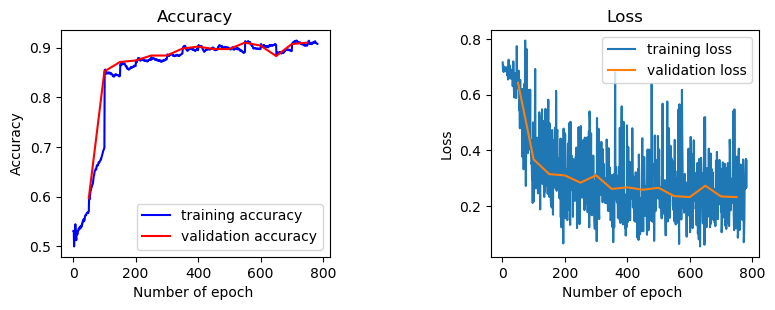

In [112]:
mm.plot_acc_loss(steps_loss_train=histories_per_step.steps, loss_train=histories_per_step.losses,
                 steps_acc_train=histories_per_step.steps, accuracy_train=histories_per_step.accuracies,
                 steps_loss_eval=histories_per_step.val_steps, loss_eval=histories_per_step.val_losses,
                 steps_acc_eval=histories_per_step.val_steps, accuracy_eval=histories_per_step.val_accuracies)

### Get more information

In [113]:
print(model.metrics)
print(model.metrics_names)

['loss', 'accuracy']


In [114]:
history.epoch

[0]

In [115]:
history.params

{'batch_size': None,
 'epochs': 1,
 'steps': 782,
 'samples': 782,
 'verbose': 0,
 'do_validation': True,
 'metrics': ['loss', 'accuracy', 'val_loss', 'val_accuracy']}

In [116]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [117]:
# dir(history)

### Exploration of the model's structure

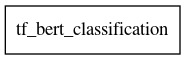

In [118]:
tf.keras.utils.plot_model(model,
                          'model.png',
                          show_shapes=True)

In [119]:
model.inputs

{'attention_mask': <tf.Tensor 'attention_mask_1:0' shape=(None, 512) dtype=int32>,
 'input_ids': <tf.Tensor 'input_ids_1:0' shape=(None, 512) dtype=int32>,
 'token_type_ids': <tf.Tensor 'token_type_ids_1:0' shape=(None, 512) dtype=int32>}

In [120]:
model.outputs

[<tf.Tensor 'tf_bert_classification_1/Identity:0' shape=(None, 2) dtype=float32>]

In [121]:
model.layers

In [122]:
# _inbound_nodes and inbound_nodes give the same !
# to see method available: dir(model.layers[2])
for layer in model.layers:
    print(layer.name, layer._inbound_nodes, layer._outbound_nodes)

bert [] []
dropout_37 [] []
classifier [] []


### Validation of the model

#### Making prediction

In [123]:
# get probablility for each classes
if model.name=='custom_tf_bert_classification':
        print('custom model: {}'.format(model.name))
        y_pred = tf.nn.softmax(model.predict(valid_dataset))
elif model.name=='tf_bert_classification':
        print('standard model: {}'.format(model.name))
        y_pred = tf.squeeze(tf.nn.softmax(model.predict(valid_dataset)))

standard model: tf_bert_classification


In [124]:
y_pred.shape

TensorShape([1000, 2])

In [125]:
# get predicted classes
y_pred_argmax = tf.math.argmax(y_pred, axis=1)        

In [126]:
(y_pred_argmax).shape

TensorShape([1000])

#### Extracting true classes

In [127]:
# extracting and flatten true classes
y_true_tf=valid_dataset.map(pp.label_extraction).flat_map(lambda x: valid_dataset.from_tensor_slices(x))

In [128]:
y_true=list(y_true_tf.as_numpy_iterator())

In [129]:
len(y_true), len(y_pred_argmax)

(1000, 1000)

#### Model performance

In [130]:
print(classification_report(y_true, y_pred_argmax, target_names=info.features["label"].names))

              precision    recall  f1-score   support

         neg       0.97      0.80      0.88       503
         pos       0.83      0.97      0.89       497

    accuracy                           0.89      1000
   macro avg       0.90      0.89      0.89      1000
weighted avg       0.90      0.89      0.89      1000



In [131]:
mm.print_metrics(y_true, y_pred_argmax, mode='')

Model performance on the  dataset:
   Metric             
accuracy...........   0.8860
recall.............   0.9738
auc................   0.8865
precision (p=0.5)..   0.8274
precision (avg)....   0.8187
precision (micro)..   0.8860
precision (macro)..   0.8980
f1.................    0.8946
r2.................    0.5440


#### Confusion matrix

In [132]:
plt.rcParams['figure.figsize'] = [10, 7]

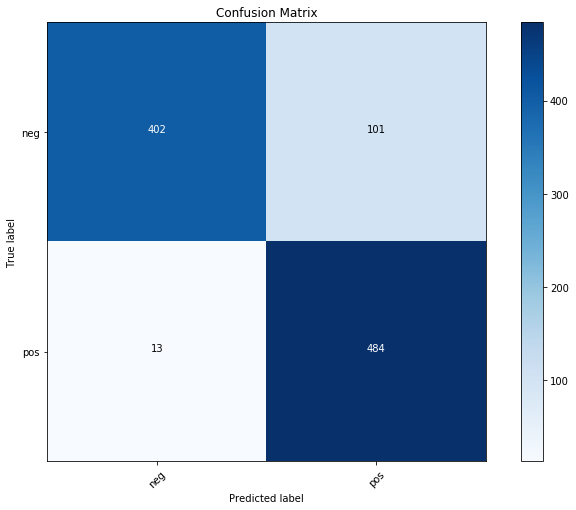

In [133]:
mm.plot_confusion_matrix(confusion_matrix(y_true, y_pred_argmax), info.features["label"].names)

#### ROC curves

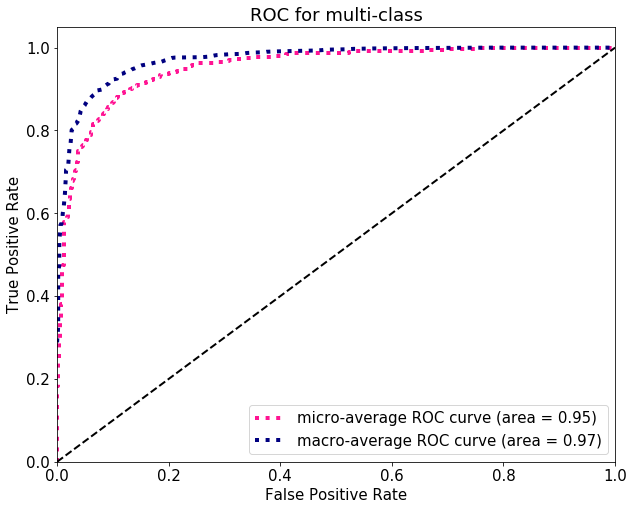

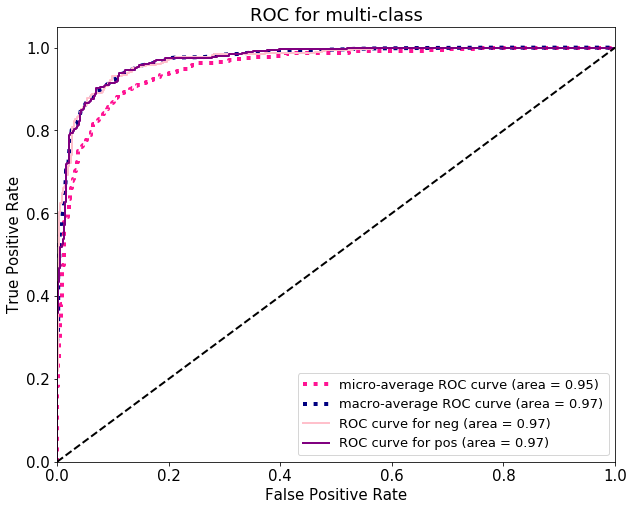

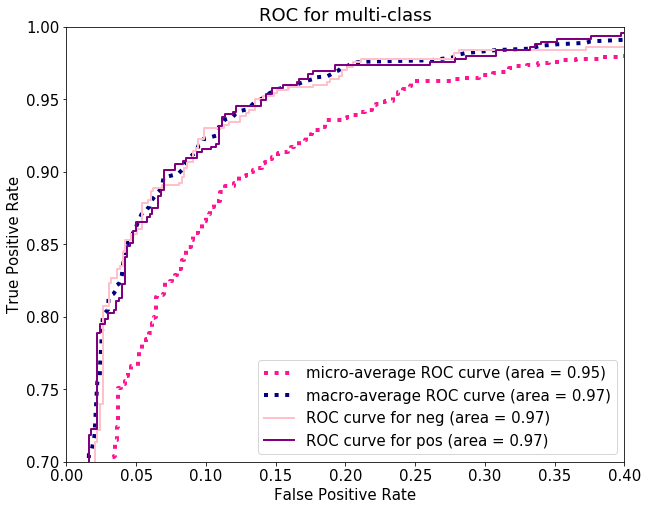

In [134]:
mm.roc_curves(to_categorical(y_true), y_pred.numpy(), info.features["label"].names)

### Inference

In [166]:
# getting a random example from the test data
for i in valid_data_np.shuffle(100).take(1):
    example = i['sentence']
    print('sentence: {}\nlabel:    {}'.format(i['sentence'].numpy().decode(), info.features["label"].names[i['label'].numpy()]))
    
text_en = [example.numpy().decode()]

sentence: The first word i can find to describe this movie is Awful. This movie is one of the worst movies I have ever seen. First of all is the plot a very thin plot (Wont comment further on this part) and a plot which a lot of movies from this genre is following. This makes the movie so bad, because you know whats going to happen. Secondly does the movie contain a lot of questions which never is revealed. One of the questions (and this is no spoiler) is: WHAT THE HELL ARE THE KIDS DOING IN THAT CORN!!!!!!!!!! Thirdly is the characters very bad, not only because the movie is bad, but also because of the sorry actors. They are bad as they can be. The last thing that make this movie bad, is that its a horror movie. You are supposed to be scared of the killings or the sudden shocks, but you are not scared, you a not horrified because you know whats going to happen. Conclusion: The movie is as bad as the movie about the killer ants! I hoped that it was a very great movie but because the s

In [167]:
# conda install googletrans
#from googletrans import Translator

# translate some example in some languages
# original entry:
# Role reversal remake of 1942's "The Major and the Minor" has Jerry Lewis stepping into the part originally played by Ginger Rogers, but unfortunately 
# this anemic outing is missing a lot more than just Ginger. Lewis attempts to pass for a child when boarding a train; he's successful, but the deception 
# leads to a string of comic and romantic confusions. Sidney Sheldon adapted the screenplay, tossing in musical moments for Dean Martin (playing yet 
# another in his stable of second bananas) and a jewel robbery subplot (which is dire). Diana Lynn, who played the wily teenager in the original film, 
# plays Lewis' love interest here. She's cute; Jerry isn't. *1 2 from ****
#text_en = ["Role reversal remake of 1942's 'The Major and the Minor' has Jerry Lewis stepping into the part originally played by Ginger Rogers, but unfortunately this anemic outing is missing a lot more than just Ginger. Lewis attempts to pass for a child when boarding a train; he's successful, but the deception leads to a string of comic and romantic confusions. Sidney Sheldon adapted the screenplay, tossing in musical moments for Dean Martin (playing yet another in his stable of second bananas) and a jewel robbery subplot (which is dire). Diana Lynn, who played the wily teenager in the original film, plays Lewis' love interest here. She's cute; Jerry isn't. *1 2 from ****"]
#text_de = ["Das Rollentausch-Remake von 'The Major and the Minor' aus dem Jahr 1942 lässt Jerry Lewis in die Rolle von Ginger Rogers eintreten, aber leider fehlt diesem anämischen Ausflug viel mehr als nur Ginger. Lewis versucht beim Einsteigen in einen Zug als Kind zu gelten. Er ist erfolgreich, aber die Täuschung führt zu einer Reihe von komischen und romantischen Verwirrungen. Sidney Sheldon adaptierte das Drehbuch und warf musikalische Momente für Dean Martin (der noch einen weiteren in seinem Stall mit zweiten Bananen spielt) und eine Nebenhandlung über Juwelenraub (was schrecklich ist) ein. Diana Lynn, die im Originalfilm den schlauen Teenager spielte, spielt hier Lewis' Liebesinteresse. Sie ist süß; Jerry aber nicht. * 1 2 von ****"]
#text_fr = ["Le remake d'inversion des rôles de 'The Major and the Minor' de 1942 a Jerry Lewis entrer dans le rôle initialement joué par Ginger Rogers, mais malheureusement cette sortie anémique manque beaucoup plus que juste Ginger. Lewis tente de passer pour un enfant à bord d'un train; il a réussi, mais la tromperie mène à une chaîne de confusions comiques et romantiques. Sidney Sheldon a adapté le scénario, jetant des moments musicaux pour Dean Martin (jouant encore un autre dans son écurie de secondes bananes) et une intrigue secondaire de vol de bijoux (ce qui est terrible). Diana Lynn, qui a joué l'adolescente astucieuse dans le film original, joue l'intérêt amoureux de Lewis ici. Elle est mignonne; Jerry ne l'est pas. * 1 2 de ****"]
#translator = Translator()
#text_en = example.numpy().decode()
#test = translator.translate("Hello, this is a test.", dest='fr')
#print(test.text)
#print(text_en)
#text_fr = translator.translate(text_en, dest='fr').text
#text_de = translator.translate(text_en, dest='de').text
#print(text_fr, '\n', text_de)

In [168]:
# conda install google-cloud-translate
from google.cloud import translate_v2 as translate
translate_client = translate.Client()

text_fr = [translate_client.translate(text_en[0], target_language='fr')['translatedText']]
text_de = [translate_client.translate(text_en[0], target_language='de')['translatedText']]

print(text_fr, '\n', text_de)

['Le premier mot que je peux trouver pour décrire ce film est terrible. Ce film est l&#39;un des pires films que j&#39;aie jamais vus. Tout d&#39;abord, l&#39;intrigue est une intrigue très mince (ne commenterez pas plus loin sur cette partie) et une intrigue que beaucoup de films de ce genre suivent. Cela rend le film si mauvais, car vous savez ce qui va se passer. Deuxièmement, le film contient-il beaucoup de questions qui ne sont jamais révélées. L&#39;une des questions (et ce n&#39;est pas un spoiler) est: QUE FONT LES ENFANTS DANS CE MAÏS !!!!!!!!!! Troisièmement, les personnages sont très mauvais, non seulement parce que le film est mauvais, mais aussi à cause des acteurs désolés. Ils sont aussi mauvais qu&#39;ils peuvent l&#39;être. La dernière chose qui rend ce film mauvais, c&#39;est que c&#39;est un film d&#39;horreur. Vous êtes censé avoir peur des tueries ou des chocs soudains, mais vous n&#39;avez pas peur, vous n&#39;êtes pas horrifié parce que vous savez ce qui va se pas

In [169]:
# had to revert the changes here because lime does not accept another argument in the function
def made_prediction(text):
    print('example of input:\n\n{}\n \nlength:{}\n'.format(text[0], len(text)))
    #print(‘text:{} length:{}\n’.format(text, len(text)))
    # get probablility for each classes
    tokens=tokenizer.batch_encode_plus(text, return_tensors="tf", pad_to_max_length=True, max_length=MAX_LENGTH)
    digits=model.predict(tokens)
    if model.name=='custom_tf_bert_classification':
        print('custom model: {}'.format(model.name))
        y_single_pred = tf.nn.softmax(digits)
    elif model.name=='tf_bert_classification':
        print('standard model: {}'.format(model.name))
        temp=tf.nn.softmax(digits)
        y_single_pred = tf.squeeze(temp)
    return y_single_pred.numpy()

In [170]:
y_single_pred_en=made_prediction(text_en)
y_single_pred_de=made_prediction(text_de)
y_single_pred_fr=made_prediction(text_fr)

example of input:

The first word i can find to describe this movie is Awful. This movie is one of the worst movies I have ever seen. First of all is the plot a very thin plot (Wont comment further on this part) and a plot which a lot of movies from this genre is following. This makes the movie so bad, because you know whats going to happen. Secondly does the movie contain a lot of questions which never is revealed. One of the questions (and this is no spoiler) is: WHAT THE HELL ARE THE KIDS DOING IN THAT CORN!!!!!!!!!! Thirdly is the characters very bad, not only because the movie is bad, but also because of the sorry actors. They are bad as they can be. The last thing that make this movie bad, is that its a horror movie. You are supposed to be scared of the killings or the sudden shocks, but you are not scared, you a not horrified because you know whats going to happen. Conclusion: The movie is as bad as the movie about the killer ants! I hoped that it was a very great movie but beca

In [171]:
y_single_pred_en

array([0.9889965 , 0.01100347], dtype=float32)

In [172]:
y_single_pred_de

array([0.41480222, 0.58519775], dtype=float32)

In [173]:
y_single_pred_fr

array([0.9030162 , 0.09698379], dtype=float32)

In [174]:
info.features["label"].names[tf.math.argmax(y_single_pred_en).numpy()]

'neg'

In [175]:
info.features["label"].names[tf.math.argmax(y_single_pred_de).numpy()]

'pos'

In [176]:
info.features["label"].names[tf.math.argmax(y_single_pred_fr).numpy()]

'neg'

### Model interpretation

In [177]:
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=info.features["label"].names)

In [178]:
exp_en = explainer.explain_instance(text_en[0], made_prediction, num_features=6)

example of input:

The first word i can find to describe this movie is Awful. This movie is one of the worst movies I have ever seen. First of all is the plot a very thin plot (Wont comment further on this part) and a plot which a lot of movies from this genre is following. This makes the movie so bad, because you know whats going to happen. Secondly does the movie contain a lot of questions which never is revealed. One of the questions (and this is no spoiler) is: WHAT THE HELL ARE THE KIDS DOING IN THAT CORN!!!!!!!!!! Thirdly is the characters very bad, not only because the movie is bad, but also because of the sorry actors. They are bad as they can be. The last thing that make this movie bad, is that its a horror movie. You are supposed to be scared of the killings or the sudden shocks, but you are not scared, you a not horrified because you know whats going to happen. Conclusion: The movie is as bad as the movie about the killer ants! I hoped that it was a very great movie but beca

In [179]:
# will do 5'000 permutations/selections of the original sentence and made prediction
exp_de = explainer.explain_instance(text_de[0], made_prediction, num_features=6)

example of input:

Das erste Wort, das ich finden kann, um diesen Film zu beschreiben, ist schrecklich. Dieser Film ist einer der schlechtesten Filme, die ich je gesehen habe. Zuallererst ist die Handlung eine sehr dünne Handlung (wird diesen Teil nicht weiter kommentieren) und eine Handlung, der viele Filme aus diesem Genre folgen. Das macht den Film so schlecht, weil Sie wissen, was passieren wird. Zweitens enthält der Film viele Fragen, die nie offengelegt werden. Eine der Fragen (und das ist kein Spoiler) ist: WAS ZUR HÖLLE TUN DIE KINDER IN DIESEM MAIS !!!!!!!!!! Drittens sind die Charaktere sehr schlecht, nicht nur weil der Film schlecht ist, sondern auch wegen der traurigen Schauspieler. Sie sind schlecht, wie sie sein können. Das Letzte, was diesen Film schlecht macht, ist, dass es ein Horrorfilm ist. Du sollst Angst vor den Morden oder den plötzlichen Schocks haben, aber du hast keine Angst, du bist nicht entsetzt, weil du weißt, was passieren wird. Fazit: Der Film ist genauso

In [180]:
exp_fr = explainer.explain_instance(text_fr[0], made_prediction, num_features=6)

example of input:

Le premier mot que je peux trouver pour décrire ce film est terrible. Ce film est l&#39;un des pires films que j&#39;aie jamais vus. Tout d&#39;abord, l&#39;intrigue est une intrigue très mince (ne commenterez pas plus loin sur cette partie) et une intrigue que beaucoup de films de ce genre suivent. Cela rend le film si mauvais, car vous savez ce qui va se passer. Deuxièmement, le film contient-il beaucoup de questions qui ne sont jamais révélées. L&#39;une des questions (et ce n&#39;est pas un spoiler) est: QUE FONT LES ENFANTS DANS CE MAÏS !!!!!!!!!! Troisièmement, les personnages sont très mauvais, non seulement parce que le film est mauvais, mais aussi à cause des acteurs désolés. Ils sont aussi mauvais qu&#39;ils peuvent l&#39;être. La dernière chose qui rend ce film mauvais, c&#39;est que c&#39;est un film d&#39;horreur. Vous êtes censé avoir peur des tueries ou des chocs soudains, mais vous n&#39;avez pas peur, vous n&#39;êtes pas horrifié parce que vous savez

In [181]:
exp_en.as_list()

[('bad', -0.23345755442734928),
 ('worst', -0.22521758823485355),
 ('Awful', -0.0969653177106366),
 ('best', 0.0852990960647112),
 ('unseen', -0.03691200925316274),
 ('is', -0.033695595176058225)]

In [182]:
exp_de.as_list()

[('besten', 0.17026000917575024),
 ('schlecht', -0.14567096020728382),
 ('schrecklich', -0.10754755260203672),
 ('Handlung', -0.0745793160402048),
 ('sehr', 0.06849384209646898),
 ('großartiger', 0.0663899974554218)]

In [183]:
exp_fr.as_list()

[('mauvais', -0.2660861154080044),
 ('terrible', -0.13939036788860745),
 ('est', -0.10350457279092466),
 ('mauvaise', -0.09209665801811019),
 ('acteurs', -0.09049917705213875),
 ('bon', 0.07929074711274808)]

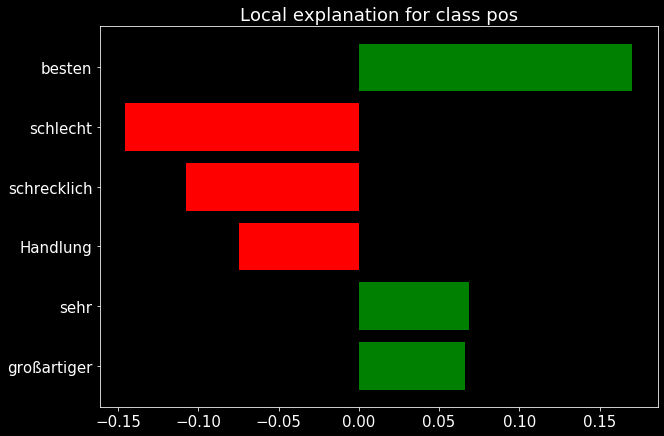

In [184]:
plt.style.use('dark_background')
fig = exp_de.as_pyplot_figure()

In [185]:
exp_de.show_in_notebook(text=True)

In [ ]:
exp_de.save_to_file('ex_de.html')

In [ ]:
from IPython.display import IFrame    
IFrame(src="ex_de.html", width=900, height=350)

In [ ]:
from IPython.core.display import display, HTML
display(HTML('<iframe src=ex_de.html width=900 style="background: #FFFFFF;" height=350></iframe>'))

/home/.conda-env/env_multilingual_class/lib/python3.7/site-packages/IPython/core/display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


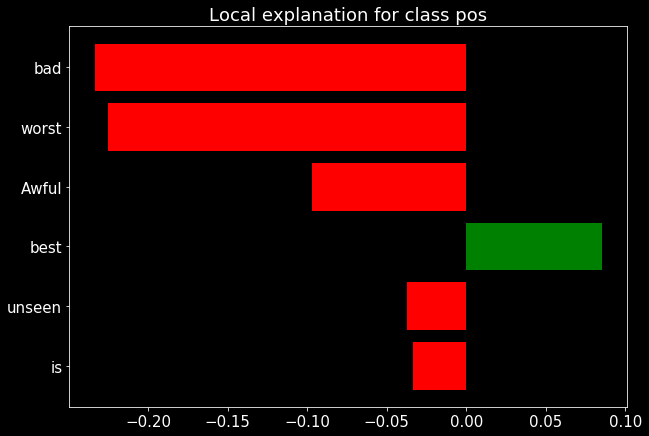

In [ ]:
plt.style.use('dark_background')
fig = exp_en.as_pyplot_figure()

In [ ]:
exp_en.show_in_notebook(text=True)

In [ ]:
exp_en.save_to_file('ex_en.html')

In [ ]:
from IPython.display import IFrame    
IFrame(src="ex_en.html", width=900, height=350)

In [ ]:
from IPython.core.display import display, HTML
display(HTML('<iframe src=ex_en.html width=900 style="background: #FFFFFF;" height=350></iframe>'))

/home/.conda-env/env_multilingual_class/lib/python3.7/site-packages/IPython/core/display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


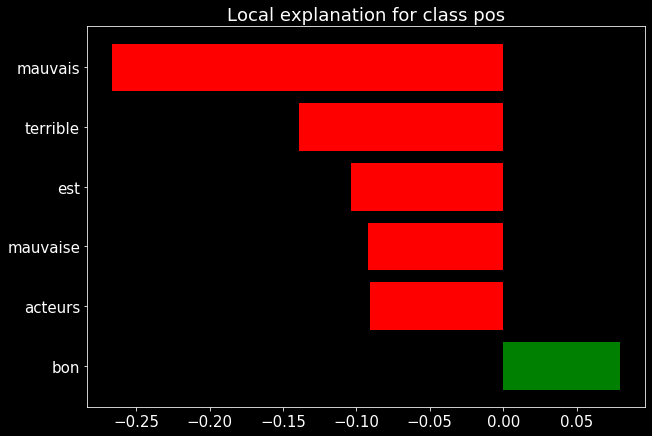

In [ ]:
plt.style.use('dark_background')
fig = exp_fr.as_pyplot_figure()

In [ ]:
exp_fr.show_in_notebook(text=True)

In [ ]:
exp_fr.save_to_file('ex_fr.html')

In [ ]:
from IPython.display import IFrame    
IFrame(src="ex_fr.html", width=900, height=350)

In [ ]:
from IPython.core.display import display, HTML
display(HTML('<iframe src=ex_fr.html width=900 style="background: #FFFFFF;" height=350></iframe>'))

/home/.conda-env/env_multilingual_class/lib/python3.7/site-packages/IPython/core/display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


### Online Predictions

In [ ]:
#client = Client()
#client.get_bucket('multilingual_text_classification')